# Pytorch code percolation model with ResNet50

## parameter choices

In [1]:
myseed=111111
width= 20
nimages= 100
img_sizeX= 100
img_sizeY= img_sizeX

validation_split= 0.1
batch_size= 1024
num_epochs= 10
myepochs=num_epochs
# mylr= 0.01
# mywd= 1e-6

dataname='L'+str(width)+'-'+str(nimages)+'-s'+str(img_sizeX)

datasrc  = '/storage/disqs/'+'ML-Data/Anderson/Images/'
datapath = datasrc+dataname # SC-RTP
devhomepath = '/home/epp/phupqr/PX319MLPhases/'
#datasrc  = '/Users/danlo/Documents/PX319MLPhases_Data/'
#datapath = datasrc+dataname # Local Machine (Laptop)
#devhomepath = /Users/danlo/Documents/PX319MLPhases
    
print(dataname,"\n",datapath)

method='PyTorch-resnet50-'+str(myseed)+'-e'+str(num_epochs) #+'-bs'+str(batch_size)
modelname = 'Model_'+method+'_'+dataname+'.pth'
historyname = 'History_'+method+'_'+dataname+'.pkl'
print(method,"\n",modelname,"\n",historyname)

savepath = './'+dataname+'/'
import os
try:
    os.mkdir(savepath)
except FileExistsError:
    pass

modelpath = savepath+modelname
historypath = savepath+historyname
print(savepath,modelpath,historypath)

L20-100-s100 
 /storage/disqs/ML-Data/Anderson/Images/L20-100-s100
PyTorch-resnet50-111111-e10 
 Model_PyTorch-resnet50-111111-e10_L20-100-s100.pth 
 History_PyTorch-resnet50-111111-e10_L20-100-s100.pkl
./L20-100-s100/ ./L20-100-s100/Model_PyTorch-resnet50-111111-e10_L20-100-s100.pth ./L20-100-s100/History_PyTorch-resnet50-111111-e10_L20-100-s100.pkl


## initializations

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#seed=42
import torch
torch.manual_seed(myseed)
import numpy as np
np.random.seed(myseed+1)

In [4]:
from __future__ import print_function, division
# import os
print('torch version:',torch.__version__)
import sklearn
print('sklearn version:', sklearn.__version__)

torch version: 1.2.0
sklearn version: 0.21.3


In [5]:
import torchvision
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import time
import os
import re
import copy

In [6]:
t=torch.Tensor()
print('current device: ', t.device, t.dtype, t.layout)

# switch to GPU if available
device=t.device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print('chosen device: ',device)

current device:  cpu torch.float32 torch.strided
chosen device:  cuda:0


## starting the main code

In [7]:
# img_sizeX= 100
# img_sizeY= 100 #img_sizeX
# validation_split= 0.1

In [8]:
class MyImageFolder2(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(MyImageFolder2, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [9]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [10]:
os.getcwd()

'/home/epp/phupqr/PX319MLPhases/MachineLearning-Anderson/src'

In [11]:
def set_new_training_data(datapath):

    global training_set
    training_set=0
    global validation_set
    validation_set=0
    # dataname='L20-100-s100'
    # path='../../../../../../../media/phrhmb/Datasets_DisQS/'+dataname
    # path='/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname

    global transform
    transform=transforms.Compose([torchvision.transforms.Resize((32,32)),
                                  torchvision.transforms.ToTensor()])


    #path = datapath 
    global whole_dataset
    whole_dataset=MyImageFolder2(root=datapath, transform=transform)


    global data_size
    data_size = len(whole_dataset)
    print(data_size)
    # validation_split=0.1
    global split
    split=int(np.floor(validation_split*data_size))
    global training
    training=int(data_size-split)
    # split the data into training and validation
    training_set, validation_set= torch.utils.data.random_split(whole_dataset,(training,split))


    # batch_size=1024
    global train
    train = torch.utils.data.DataLoader(
            dataset=training_set,
            batch_size=batch_size,
            shuffle=True)
    # enum_train=enumerate(train)
    # len_train=len(train)

    global val
    val = torch.utils.data.DataLoader(
            dataset=validation_set,
            batch_size=batch_size,
            shuffle=False)
    # enum_val=enumerate(val)
    # len_val=len(val)
    # print(len_train,len_val)


    global class_names
    class_names =whole_dataset.classes
    class_names


    global inputs,labels,path
    inputs,labels,path= next(iter(val))
    labels.shape


    global img_sizeX,img_sizeY
    img_sizeX,img_sizeY= inputs.shape[-1],inputs.shape[-2]
    img_sizeY


    global num_of_train_samples
    num_of_train_samples = len(training_set) # total training samples
    global num_of_test_samples
    num_of_test_samples = len(validation_set) #total validation samples
    global steps_per_epoch
    steps_per_epoch = np.ceil(num_of_train_samples // batch_size)
    global len_train
    len_train=len(train)
    global len_val
    len_val=len(val)
    global number_classes
    number_classes= len(class_names)
    print('number of samples in the training set:', num_of_train_samples)
    print('number of samples in the validation set:', num_of_test_samples )
    print('number of samples in a batch',len_train) 
    print('number of samples in a batch',len_val)
    print('number of classes',number_classes )
    
    global model
    model=models.resnet50(pretrained=True, progress=True)

    global num_ftrs
    num_ftrs = model.fc.in_features # number of input features of the last layer which is fully connected (fc)

    #We modify the last layer in order to have 2 output: percolating or not
    model.fc=nn.Linear(num_ftrs, number_classes )
     #the model is sent to the GPU
    model = model.to(device)
    
    # defining the optimizer

    global optimizer
    optimizer=torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
    # defining the loss function
    global criterion
    criterion = nn.CrossEntropyLoss()

    global exp_lr_scheduler
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()

    #print(model)
    
    #the model is sent to the GPU
    model = model.to(device)

## building the CNN

In [12]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [13]:
# for param in model.parameters():
#     print(param.shape)

In [14]:
def train_model(model,criterion, optimizer, num_epochs, scheduler, batch_size):
    global accuracy, _loss, val_accuracy, val_loss, epochs, val_epochs 
    since=time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    accuracy=[]
    _loss=[]
    val_accuracy=[]
    val_loss=[]
    epochs=[]
    val_epochs=[]
       
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1,num_epochs))
        print('-' * 10)
        
        #two phases: training and validating
        for phase in [train,val]:
            if phase == train:
                print('Training', end=" ")
                model.train() # set the model to training mode
                batches= len_train
            else:
                print('Validation', end=" ")
                model.eval() # set the model to evaluation mode
                batches= len_val
                
            #batches= len(list(enum_data))
            print('with', batches, 'batches')
            running_loss=0.0
            running_corrects=0.0
            
            # Here's where the training happens
            # print('--- iterating through data ...')
            
            for i, (inputs,labels,paths) in enumerate(phase):
                
                print(i*100//batches, '%', end="\r", flush=True)
                
                inputs=inputs.to(device)
                labels=labels.to(device)
                #paths=paths.to(device)
                                
                #put the gradient to zero to avoid accumulation during back propagation
                optimizer.zero_grad()
                                
                #now we need to carry out the forward and backward process in different steps
                #First the forward training
                #for the training step we need to log the loss
                with torch.set_grad_enabled(phase==train):
                    outputs=model(inputs)
                    _, preds= torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                
                #still for the training phase we need to implement backword process and optimization
                
                    if phase==train:
                        loss.backward()
                        optimizer.step()
                        
                # We want variables to hold the loss statistics
                #loss.item() extract the loss value as float then it is multiply by the batch size
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+= torch.sum(preds==labels.data)
                
            if phase == train:
                scheduler.step()            
            
            if phase == train:
                epoch_loss= running_loss/len(phase.dataset)
                epoch_acc = running_corrects.double()/ len(phase.dataset)
                print('{} loss= {:4f}, accuracy= {:4f}'.format(
                    'Training result:', epoch_loss, epoch_acc))
                accuracy.append(epoch_acc)
                _loss.append(epoch_loss)
                epochs.append(epoch)
                
            if phase == val:
                epoch_loss= running_loss/len(val.dataset)
                epoch_acc = running_corrects.double()/len(val.dataset)
                print('{} val_loss= {:4f}, val_accuracy= {:4f}'.format(
                    'Validation result:', epoch_loss, epoch_acc))
                val_accuracy.append(epoch_acc)
                val_loss.append(epoch_loss)
                val_epochs.append(epoch)
                
            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == val and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model        

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs,labels,paths) in enumerate(val):

            inputs=inputs.to(device)
            labels=labels.to(device)

            outputs = model(inputs) #value of the output neurons
            _, preds = torch.max(outputs, 1) #gives the max value and stores in preds the neurons to which it belongs

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}; \n true label {}; \n path: {};'.format(class_names[preds[j]] ,
                                                                     class_names[labels[j]],paths[j])
                            )
                imshow(inputs.cpu().data[j])
                
                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
def visualize_model_misclassified(model, num_images=6): #gives shows only the misclassified images
    import re
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs,labels,paths) in enumerate(val):
            
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            outputs = model(inputs) #value of the output neurons
            _, preds = torch.max(outputs, 1) #gives the max value and stores in preds the neurons to which it belongs

            for j in range(inputs.size()[0]):
                if labels[j]!=preds[j] and abs(labels[j]-preds[j])>4:
                #print(inputs.size()[0])
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('predicted: {}; \n true label {}; \n path: {};'.format(class_names[preds[j]] ,
                                                                     class_names[labels[j]],paths[j])
                            )
                    imshow(inputs.cpu().data[j])
                
                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
        
        model.train(mode=was_training)

85000
number of samples in the training set: 76500
number of samples in the validation set: 8500
number of samples in a batch 75
number of samples in a batch 9
number of classes 18
L20-5000-s100 
 /storage/disqs/ML-Data/Anderson/Images/L20-5000-s100 
 Keras-OhtsukiConv2D-111111
./L20-5000-s100./ ./L20-5000-s100./Keras-OhtsukiConv2D-111111-model-L20-5000-s100.h5 ./L20-5000-s100./Keras-OhtsukiConv2D-111111-history-L20-5000-s100.pkl
Epoch 1/10
----------
Training with 75 batches
Training result: loss= 2.693034, accuracy= 0.112745
Validation with 9 batches
Validation result: val_loss= 3.338163, val_accuracy= 0.074588

Epoch 2/10
----------
Training with 75 batches
Training result: loss= 2.589207, accuracy= 0.124784
Validation with 9 batches
Validation result: val_loss= 2.601480, val_accuracy= 0.121882

Epoch 3/10
----------
Training with 75 batches
Training result: loss= 2.573584, accuracy= 0.127895
Validation with 9 batches
Validation result: val_loss= 2.619361, val_accuracy= 0.116471

Ep

Training result: loss= 2.134868, accuracy= 0.219079
Validation with 8 batches
Validation result: val_loss= 2.657440, val_accuracy= 0.192726

Epoch 4/10
----------
Training with 64 batches
Training result: loss= 2.111632, accuracy= 0.224173
Validation with 8 batches
Validation result: val_loss= 4.603842, val_accuracy= 0.078177

Epoch 5/10
----------
Training with 64 batches
Training result: loss= 2.095270, accuracy= 0.226976
Validation with 8 batches
Validation result: val_loss= 2.203067, val_accuracy= 0.217949

Epoch 6/10
----------
Training with 64 batches
Training result: loss= 2.086273, accuracy= 0.228354
Validation with 8 batches
Validation result: val_loss= 2.566461, val_accuracy= 0.189103

Epoch 7/10
----------
Training with 64 batches
Training result: loss= 2.069190, accuracy= 0.234547
Validation with 8 batches
Validation result: val_loss= 15.890936, val_accuracy= 0.096990

Epoch 8/10
----------
Training with 64 batches
Training result: loss= 2.045261, accuracy= 0.240555
Validat

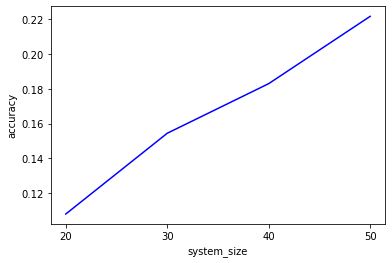

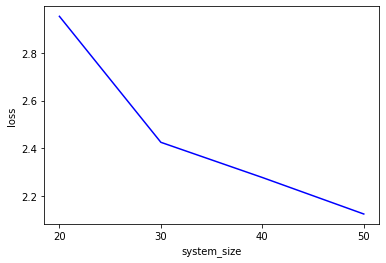

In [23]:
# train DNN and store training info in history
#sys_size_list = [20,30,40,50];
#for (sys_size in sys_size_list):

#myepochs = 1

sys_scores = []
sys_loss   = []
sys_sizes = ['20','30','40','50']

nsam_res = "-5000-s100"

for sys_size in sys_sizes:
    dataname="L" + sys_size + nsam_res
    
    #datapath = '/Users/danlo/Documents/PX319MLPhases_Data/' + dataname
    datapath = '/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname # SC-RTP

    set_new_training_data(datapath)
    
    methodformat="Keras-OhtsukiConv2D-{0}"
    method=methodformat.format(myseed)
    print(dataname,"\n",datapath,"\n",method)

    modelname = method+'-model-'+dataname+'.h5'
    historyname = method+'-history-'+dataname+'.pkl'
    print(savepath,modelpath,historypath)
    
    savepath = './'+dataname+'./'
    import os
    try:
        os.mkdir(savepath)
    except FileExistsError:
        pass
    
    modelpath = savepath+modelname
    historypath = savepath+historyname
    base_model = train_model(
        model, criterion, optimizer, num_epochs, exp_lr_scheduler, batch_size=batch_size )
    sys_scores.append(val_accuracy[-1].item())
    sys_loss.append(val_loss[-1])
    print(sys_scores)
    print(sys_loss)
    
        
print("Accuracy list: ", sys_scores)
fig=plt.figure()
plt.plot(sys_sizes, sys_scores, '-b')
plt.ylabel('accuracy')
plt.xlabel('system_size')
plt.show()
fig.savefig(devhomepath + 'MachineLearning-Anderson/src/plots/performance_metrics/System_Size/' + 'sys_size_val_accuracy-' + 'e' + str(myepochs) + '-' + nsam_res + '-' + 'seed_' + str(myseed) + '.png') 

fig=plt.figure()
plt.plot(sys_sizes, sys_loss, '-b')
plt.ylabel('loss')
plt.xlabel('system_size')
plt.show()
fig.savefig(devhomepath + 'MachineLearning-Anderson/src/plots/performance_metrics/System_Size/' + 'sys_size_loss-' + 'e' + str(myepochs) + '-' + nsam_res + '-' + 'seed_' + str(myseed) + '.png') 

In [24]:
import pandas as pd
#a = [1,2,3]
#b = [5,5,6]
#nsam_res = "-5000-s100"
data_csv = pd.DataFrame( np.array(sys_sizes) )
data_csv[1] = np.array(sys_scores)
print(data_csv)
data_csv.to_csv(devhomepath + 'MachineLearning-Anderson/src/plots/performance_metrics/System_Size/' + 'sys_size_val_accuracy-' + 'e' + str(myepochs) + '-' + nsam_res + '-' + 'seed_' + str(myseed) + '.csv')

data_csv = pd.DataFrame( np.array(sys_sizes) )
data_csv[1] = np.array(sys_loss)
print(data_csv)
data_csv.to_csv(devhomepath + 'MachineLearning-Anderson/src/plots/performance_metrics/System_Size/' + 'sys_size_loss-' + 'e' + str(myepochs) + '-' + nsam_res + '-' + 'seed_' + str(myseed) + '.csv')

    0         1
0  20  0.108118
1  30  0.154471
2  40  0.182941
3  50  0.221572
    0         1
0  20  2.953104
1  30  2.424890
2  40  2.277310
3  50  2.124221


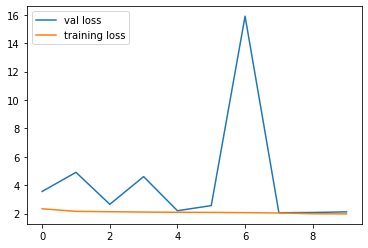

In [25]:
fig=plt.figure()
plt.plot(epochs,val_loss, label='val loss')
plt.plot(epochs,_loss, label='training loss')
plt.legend(loc='upper left')
fig.savefig(savepath+method+'_'+method+'_'+dataname+'_loss'+'.png')

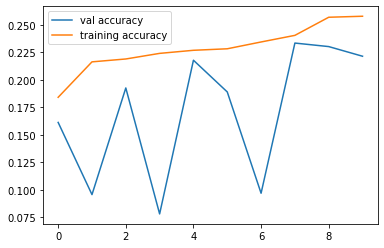

In [26]:
fig=plt.figure()
plt.plot(val_epochs,val_accuracy, label='val accuracy')
#print(val_accuracy[0].item())
plt.plot(epochs,accuracy, label='training accuracy')
plt.legend(loc='upper left')
fig.savefig(savepath+method+'_'+method+'_'+dataname+'_accuracy'+'.png')

In [27]:
# PATH = './Anderson_'+dataname+'_resnet50_'+str(num_epochs)+'_epochs_batch_size'+str(batch_size)+'.pth'
torch.save(model.state_dict(), modelpath)

## testing the quality of the learned model

Accuracy of W15.0 : 70 %
Accuracy of W15.25 : 16 %
Accuracy of W15.5 : 30 %
Accuracy of W15.75 : 13 %
Accuracy of W16.0 : 17 %
Accuracy of W16.2 : 13 %
Accuracy of W16.3 :  0 %
Accuracy of W16.4 : 24 %
Accuracy of W16.5 :  1 %
Accuracy of W16.6 :  6 %
Accuracy of W16.7 : 26 %
Accuracy of W16.8 :  3 %
Accuracy of W17.0 : 29 %
Accuracy of W17.25 :  0 %
Accuracy of W18.0 : 82 %
15


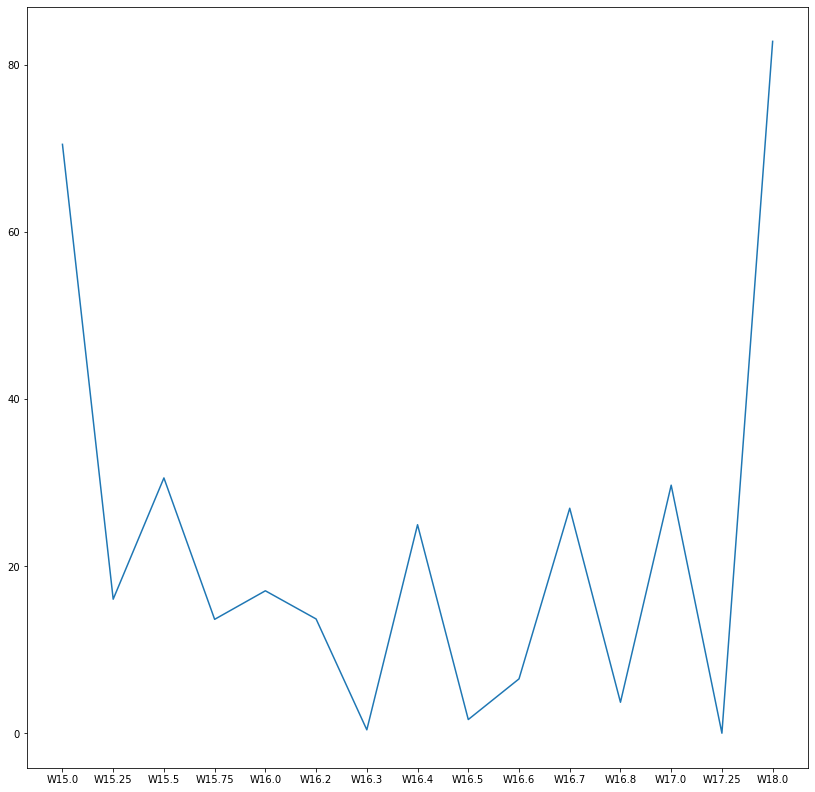

In [30]:
class_correct = list(0. for i in range(number_classes))
class_total = list(0. for i in range(number_classes))
accuracy=list(0. for i in range(number_classes))
average=list(0. for i in range(number_classes))
with torch.no_grad():
     for i, (data) in enumerate(val):
        inputs=data[0]
        labels=data[1]
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 

        c = (preds == labels).squeeze()
        for i in range(inputs.size()[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(number_classes):
    average[i]=(class_correct[i] / class_total[i])*100
    
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

print(len(average))
#fig=plt.figure()
plt.figure(figsize=(14,14))
plt.plot(class_names,average)
plt.savefig(savepath+method+'_'+dataname+'_classacc'+'.png')

In [29]:
@torch.no_grad()
def simple_confusion_matrix(model,loader):
    confusion_matrix = torch.zeros(number_classes, number_classes)
    for i, (data) in enumerate(loader):
        inputs=data[0]
        labels=data[1]
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
                
    return confusion_matrix

In [ ]:
cm=simple_confusion_matrix(model,val)
cm

In [ ]:
def confusion_matrix_torch(cm, target_names,cmap=None,title='Confusion Matrix'):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    #accuracy = np.trace(cm) / float(np.sum(cm))
    #misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig=plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)#,fontsize=40)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=30)
        plt.yticks(tick_marks, target_names,fontsize=30)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if  cm[i, j] == 0 or cm[i, j] > thresh else "black") 

#     fig=plt.figure()
    plt.tight_layout()
    plt.ylabel('True label',fontsize=40)
    plt.xlabel('Predicted label',fontsize=40)
#     plt.show()
    plt.savefig(savepath+method+'_'+dataname+'_CM'+'.png')
    plt.show()

In [ ]:
confusion_matrix_torch(cm,class_names)

In [ ]:
%%javascript
IPython.notebook.save_notebook()